In [1]:
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import math
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

import umap
import umap.plot

from tqdm import tqdm

In [2]:
class Autoencoder(Model):

    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(32, 32, 1)),
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
            ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'), 
            layers.Dense(526, activation='relu'), 
            layers.Dense(1024, activation='relu'),
            layers.Reshape((32, 32))])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
emnist_pages = []
kmnist_pages = []

num_pages = 5

for x in range(num_pages):
    emnist_pages.append(Image.open(f'../data/winnie-emnist-2/{x}.png'))
    kmnist_pages.append(Image.open(f'../data/winnie-kmnist-2/{x}.png'))

In [7]:
emnist_data = []
kmnist_data = []

letter_size = 32
letters_per_width = 80
letters_per_height = 114

e_page = np.array(emnist_pages[0])[:,:,0]

for page_n in range(num_pages):

    e_page = np.array(emnist_pages[page_n])[:,:,0]/255
    k_page = np.array(kmnist_pages[page_n])[:,:,0]/255
    for l_h in range(letters_per_height):
        for l_w in range(letters_per_width):
            if sum(sum(e_page[l_h * letter_size:(l_h + 1) * letter_size,l_w * letter_size:(l_w + 1) * letter_size])) > 80:
                emnist_data.append(e_page[l_h * letter_size:(l_h + 1) * letter_size,l_w * letter_size:(l_w + 1) * letter_size])
                kmnist_data.append(k_page[l_h * letter_size:(l_h + 1) * letter_size,l_w * letter_size:(l_w + 1) * letter_size])

emnist_data = np.array(emnist_data)
kmnist_data = np.array(kmnist_data)

In [8]:
kmnist_autoencoder =  Autoencoder(5)
emnist_autoencoder =  Autoencoder(5)

kmnist_autoencoder.load_weights('../models/dense-kmnist-2/weigths')
emnist_autoencoder.load_weights('../models/dense-emnist-2/weigths')

In [9]:
def display_ae_n_umap(ae, data):
    encoded_imgs = ae.encoder(data).numpy()
    decoded_imgs = ae.decoder(encoded_imgs).numpy()

    n = 10

    plt.figure(figsize=(20, 4))
    for i in range(n):
        id = random.randint(0,len(data))
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[id])

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[id])
    plt.show()

    encoded_imgs = ae.encoder(data).numpy()

    reducer = umap.UMAP()
    mapper = reducer.fit(encoded_imgs)

    umap.plot.points(mapper)
    plt.show()

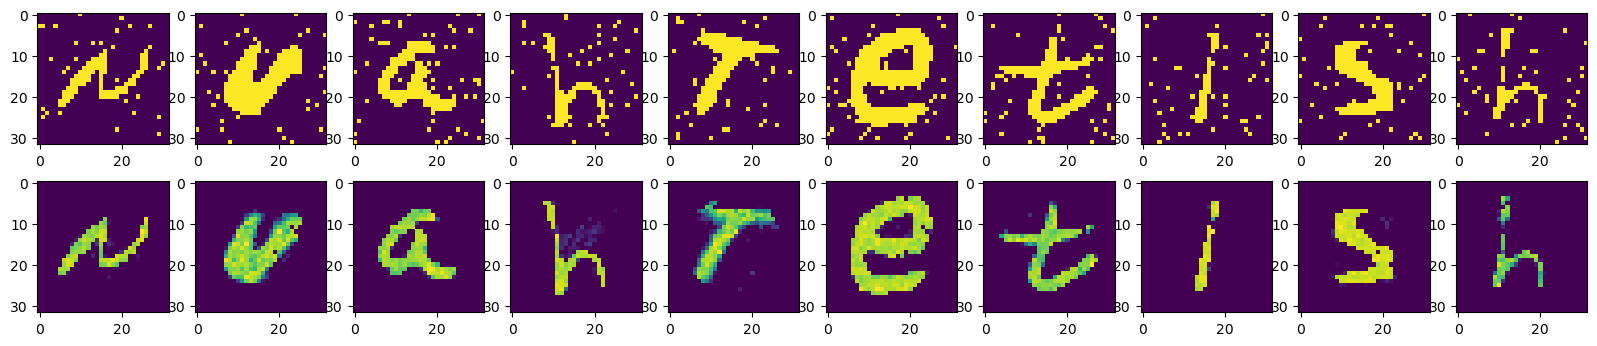

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


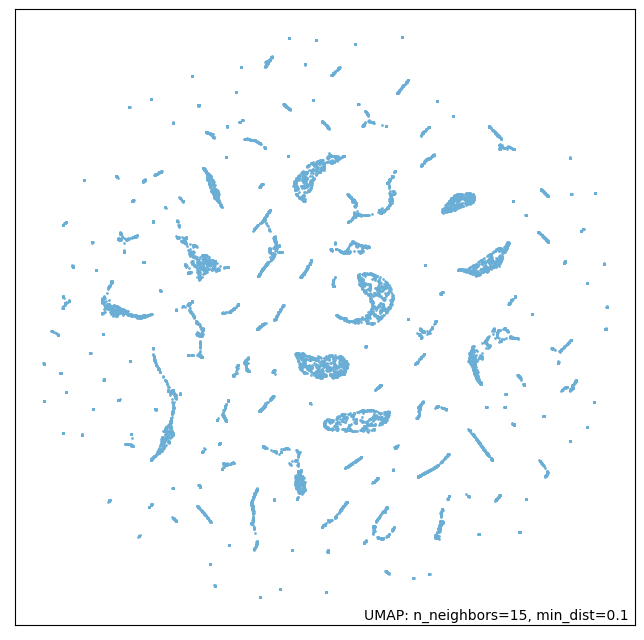

In [10]:
display_ae_n_umap(emnist_autoencoder, emnist_data)

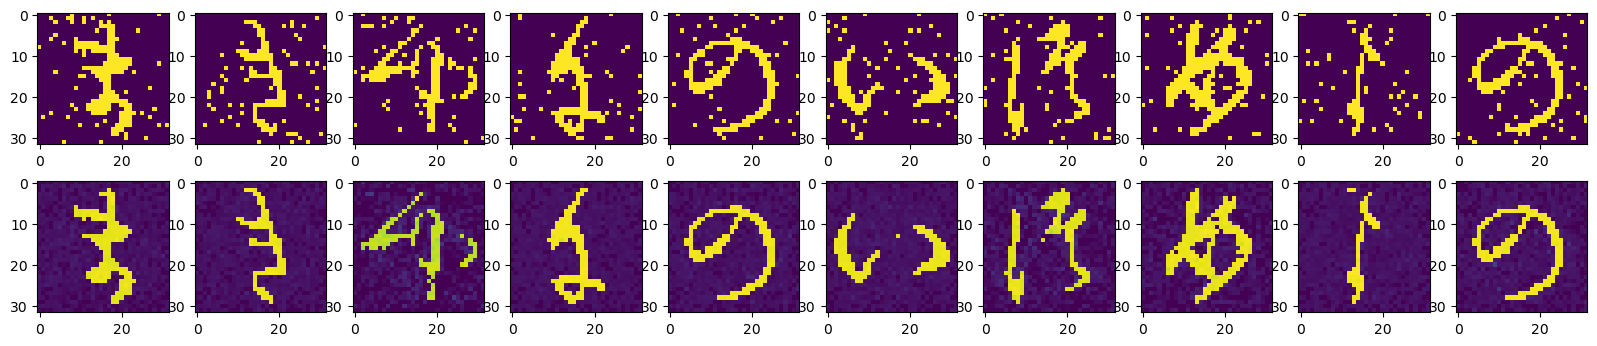

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


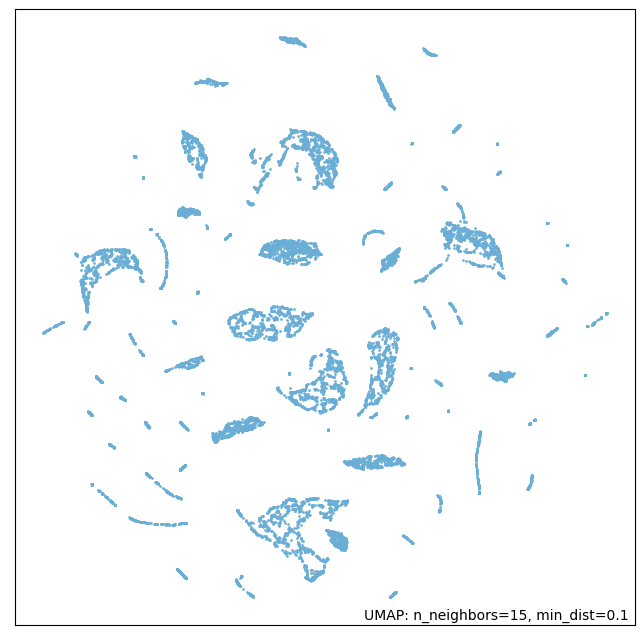

In [40]:
display_ae_n_umap(kmnist_autoencoder, kmnist_data)

In [12]:
def analyse(ae, data):
    encoded = ae.encoder(data[:10000]).numpy()

    scores = {}
    bic = {}
    meandist = {}
    for n_clust in tqdm(range(2,61)):

        gmm = GaussianMixture(n_clust, covariance_type='full', random_state=0).fit(encoded)
        pred = gmm.predict(encoded)
        scores[n_clust] = silhouette_score(encoded, pred)
        bic[n_clust] = gmm.bic(encoded)
        meandist[n_clust] = np.mean(gmm.covariances_) * n_clust


    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
    ax1.plot(list(scores.keys()), list(scores.values()), label='silhouette_score')
    ax1.legend(loc='upper left')

    ax2.plot(list(meandist.keys()), list(meandist.values()), label='covariance coef')
    ax2.legend(loc='upper left')
    plt.show()

    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

    x = list(bic.keys())
    y = list(bic.values())

    derivative_y = []
    for i in range(1, len(x)-1):
        dy = (y[i+1] - y[i-1])/(x[i+1] - x[i-1])
        derivative_y.append(dy)

    derivative_y.insert(0,derivative_y[0])
    derivative_y.append(derivative_y[-1])

    ax1.plot(x, y, label='bic')
    ax1.legend(loc='upper left')

    ax2.plot(x, derivative_y, label='bic derivative')
    ax2.legend(loc='upper left')

    plt.show()

    n_clusters = max(scores, key=scores.get)

In [13]:
def get_gmm(n_clust, ae, data):
    encoded = ae.encoder(data[:10000]).numpy()
    gmm = GaussianMixture(n_clust, covariance_type='full', random_state=0).fit(encoded)
    return gmm

100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [06:11<00:00,  6.29s/it]


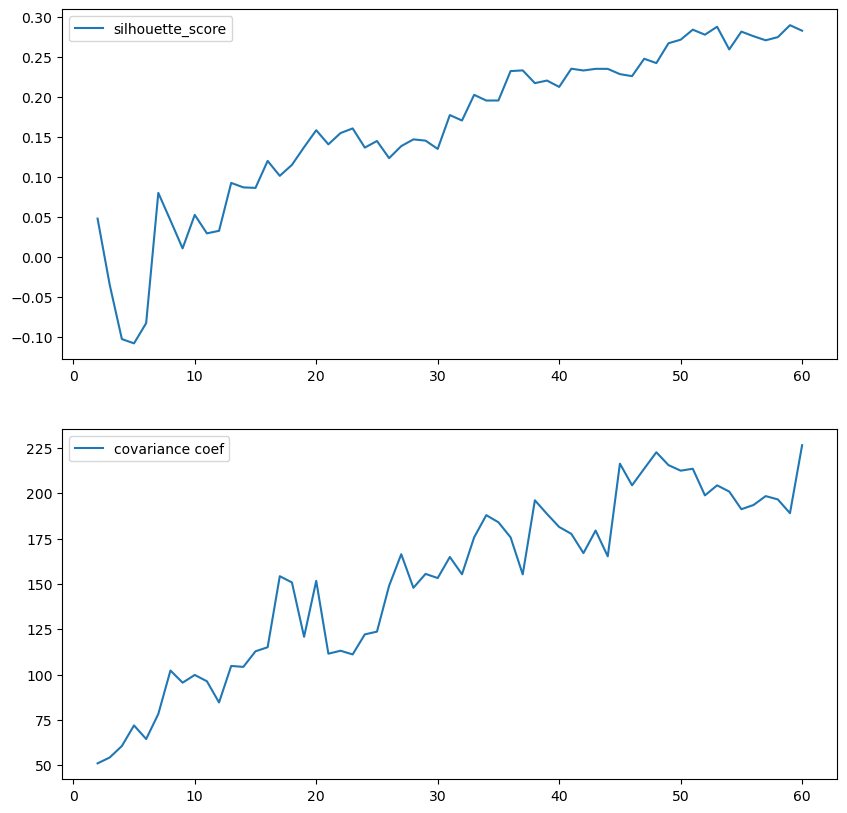

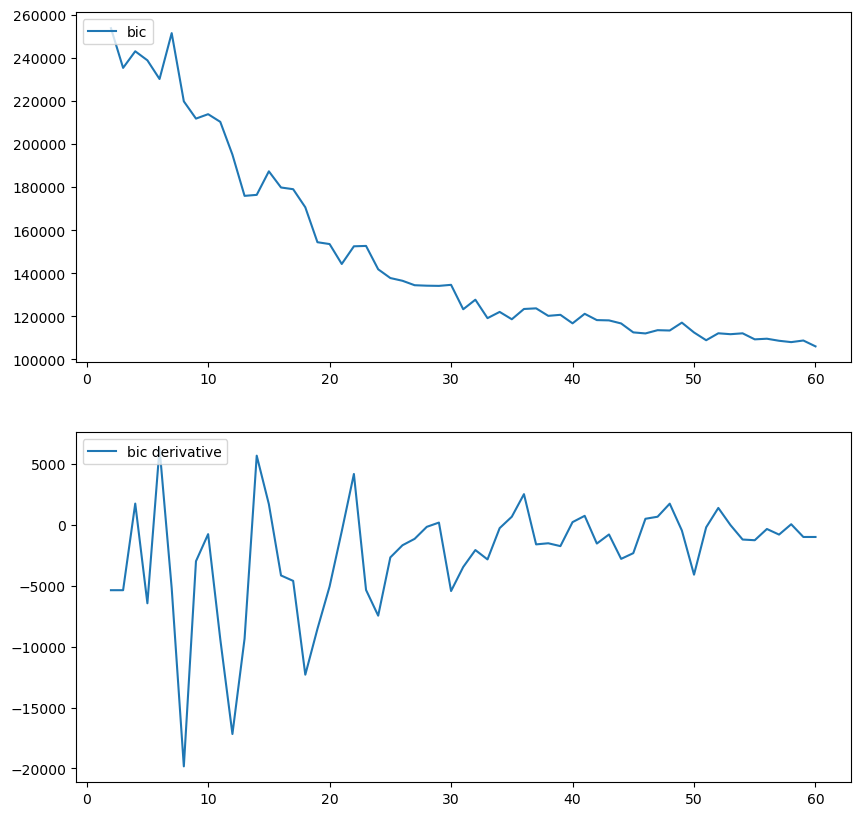

In [14]:
analyse(emnist_autoencoder, emnist_data)

100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [03:02<00:00,  3.09s/it]


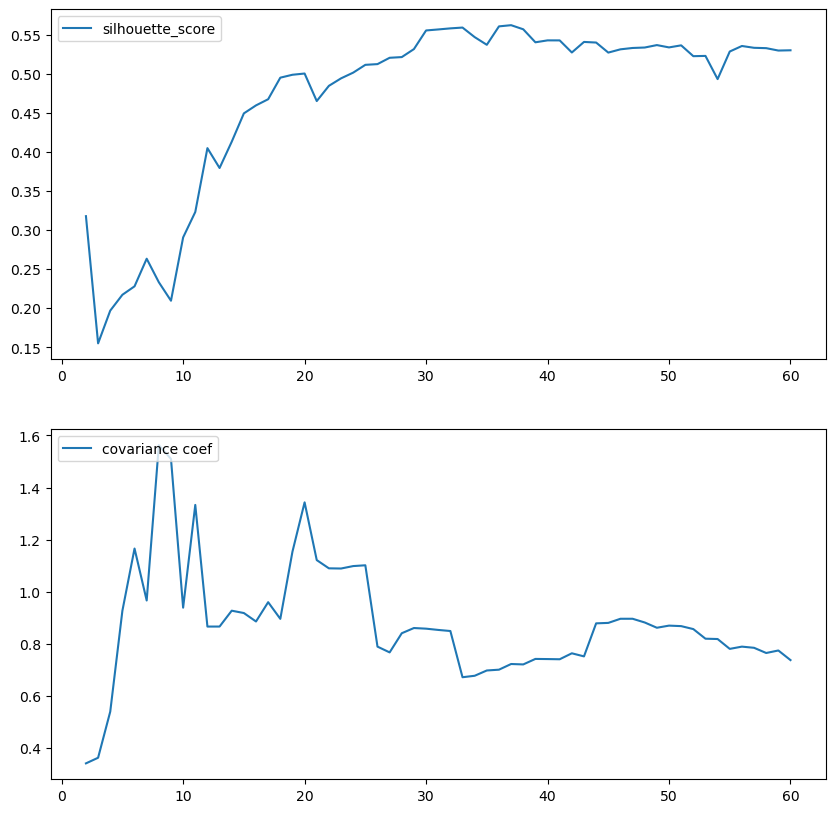

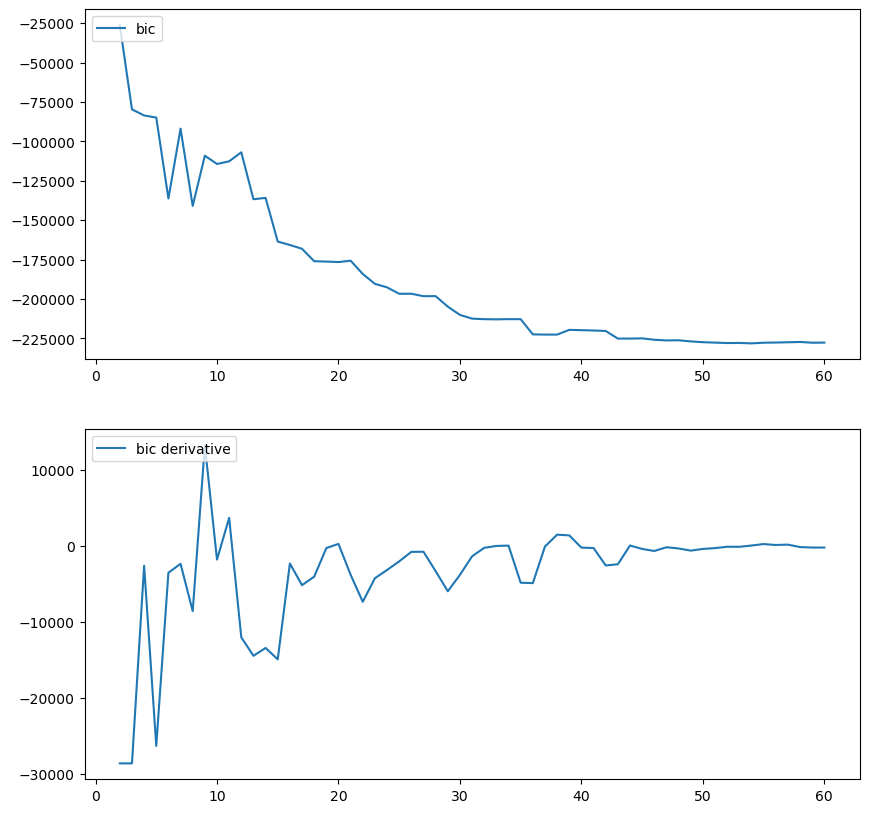

In [64]:
analyse(kmnist_autoencoder, kmnist_data)

In [93]:
k_n_clust = 36
e_n_clust = 34

kgmm = get_gmm(k_n_clust, kmnist_autoencoder, kmnist_data)
egmm = get_gmm(e_n_clust, emnist_autoencoder, emnist_data)

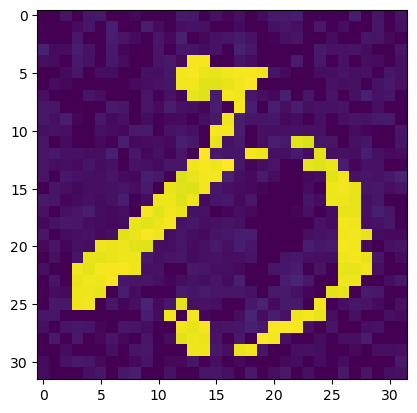

In [94]:
decoded_imgs = kmnist_autoencoder.decoder(kgmm.means_[[2,3]]).numpy()

plt.imshow(decoded_imgs[1])
plt.show()

In [95]:
k_encoded = kmnist_autoencoder.encoder(kmnist_data).numpy()
e_encoded = emnist_autoencoder.encoder(emnist_data).numpy()

kmnist_pred = kgmm.predict(k_encoded)
emnist_pred = egmm.predict(e_encoded)

In [96]:
k_labels, k_counts = np.unique(kmnist_pred, return_counts=True)
e_labels, e_counts = np.unique(emnist_pred, return_counts=True)

In [97]:
count_sort_ind = np.argsort(-k_counts)
print(k_labels[count_sort_ind])
print(k_counts[count_sort_ind])

[13  0 11  7  1 21  6 22 34 29 10 24 35 15  4 14 18  2 16 19 28 30 17  8
  3 23 26  5  9 20 31 33 12 27 32 25]
[1299 1155 1043  843  830  790  694  664  551  501  486  415  334  253
  237  235  234  234  224  214  153  141  136  113  112  108   93   89
   84   25   23   14   13   12   10    8]


In [98]:
def mapping(kmnist_pred, emnist_pred):
    k_labels, k_counts = np.unique(kmnist_pred, return_counts=True)
    e_labels, e_counts = np.unique(emnist_pred, return_counts=True)
    
    k_sort_ind = np.argsort(-k_counts)
    k_labels_sorted = k_labels[k_sort_ind]
    
    e_sort_ind = np.argsort(-e_counts)
    e_labels_sorted = e_labels[e_sort_ind]
    
    mapp = {}
        
    for id in range(len(k_labels_sorted)):
        if id >= len(e_labels_sorted):
            mapp[k_labels_sorted[id]] = e_labels_sorted[-1]    
        else:
            mapp[k_labels_sorted[id]] = e_labels_sorted[id]
    mapp = {int(k):int(v) for k,v in mapp.items()}

    return mapp

In [99]:
mapp = mapping(kmnist_pred, emnist_pred)

In [100]:
from joblib import dump, load
dump(kgmm, '../models/gmm/kgmm.joblib') 
dump(egmm, '../models/gmm/egmm.joblib') 

np.save('../models/mapping.npy', mapp) 